# Exercise 2 - Python:  Multi-class Classification and Neural Networks

## *Part One*: Multi-class Classification with Logistic Regression

Recognizing handwritten digits.  Though the source is not explicitly mentioned, it is just like the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database).

Each value of $X$ will be a 20x20 grid of values representing the grayscale intensity at that location "unrolled" into a 400-dimensional vector.  Here is an example for the first number in our data, $X^{(1)}$:

$\hspace{1cm} X^{(1)} = \begin{bmatrix}x_{(1, 1)}^{(1)},\ x_{(1, 2)}^{(1)},\ \dots\ x_{(1, 20)}^{(1)} \\
                                    x_{(2, 1)}^{(1)},\ x_{(2, 2)}^{(1)},\ \dots\ x_{(2, 20)}^{(1)} \\
                                    \vdots \\ 
                                    x_{(20, 1)}^{(1)},\ x_{(20, 2)}^{(1)},\ \dots\ x_{(20, 20)}^{(1)} \\ 
                    \end{bmatrix}
\rightarrow \begin{bmatrix} x_1^{(1)},\ x_2^{(1)},\ \dots\ x_{400}^{(1)} \end{bmatrix}
\rightarrow (x^{(1)})^T$

Here is our collection of all of the numbers for $X$:

$\hspace{1cm} X = \begin{bmatrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(400)})^T \end{bmatrix}$

---

Beginning with package imports, data loading, and initial visualization

In [108]:
import numpy as np
import pandas as pd
from scipy import optimize  # Discovering optimal parameters
from sklearn.preprocessing import OneHotEncoder  # Feature transformation
import matplotlib.pyplot as plt
import seaborn as sns

# For comparing answers
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import scipy.io as sio # Used to load the Octave/MATLAB *.mat files

plt.style.use('ggplot')

%matplotlib inline

In [219]:
# Loading in the data from the .mat files
data = sio.loadmat('ex3/ex3data1.mat')
X, y = data['X'], data['y']

# Adding the intercept term for X
X = np.insert(X,  # Array to insert value into
              0,  # Index of where to insert
              1,  # Value
              axis=1)  # Along the columns

print(X.shape)
X

(5000, 401)


array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

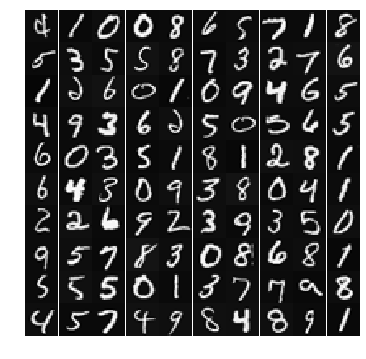

In [3]:
# Randomly sampling 100 numbers to display
random100 = X[np.random.randint(X.shape[0], size=100), 1:]  # 1: excludes the intercept

# Creating the overall figure to fill with plots of the numbers
fig = plt.figure(figsize=(6, 6))

# Loop over numbers to plot into the overall figure
for i, number in enumerate(random100):  # Enumerating to include index
    number = number.reshape(20, 20).T  # Reshape X into 20x20 array
    ax = fig.add_subplot(10, 10, i+1)  # Rows, Columns, positioning
    plt.imshow(number, cmap='gray')  # Plotting the number
    
    # Removing unnecessary components for aesthetics
    plt.grid(False)
    plt.axis('off')
    fig.subplots_adjust(wspace=0, hspace=0)
    
plt.show()

### Vectorizing Logistic Regression

We'll be taking a matrix multiplication approach to vectorize both the cost function and the gradient for logistic regression.  My previous notebooks for assignment \#2 ([Python](http://nbviewer.jupyter.org/github/JeffMacaluso/Misc/blob/master/MachineLearningMOOC/Ex2%20Python%20-%20Logistic%20Regression.ipynb) | [R](http://nbviewer.jupyter.org/github/JeffMacaluso/Misc/blob/master/MachineLearningMOOC/Ex2%20R%20-%20Logistic%20Regression.ipynb) | [Julia](http://nbviewer.jupyter.org/github/JeffMacaluso/Misc/blob/master/MachineLearningMOOC/Ex2%20Julia%20-%20Logistic%20Regression.ipynb)) already use a vectorized approach, but I'll have a little more information describing what is happening below.

- **Note:** The assignment calls for creating the functions for unregularized logistic regression and later modifying them for regularization, but I'm just going to write the functions for regularized logistic regression right away since the regularization parameter is generally just an addition at the end of the equations.

To illustrate this vectorization process, here is how we vectorize our hypothesis, $h_\theta(x)$, using matrix multiplication with the axiom that $a^Tb = b^Ta$ if $a$ and $b$ are vectors:

Defining $X$ and $\theta$ as

$\hspace{1cm} X = \begin{bmatrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(m)})^T \end{bmatrix} \hspace{0.5cm}$ and $\hspace{0.5cm} \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix}$

Computing matrix product $X\theta$:

$\hspace{1cm} X\theta = \begin{bmatrix} (x^{(1)})^T\theta \\ (x^{(2)})^T\theta \\ \vdots \\ (x^{(m)})^T\theta \end{bmatrix} \hspace{0.5cm} = \hspace{0.5cm} \begin{bmatrix} \theta^T(x^{(1)}) \\ \theta^T(x^{(2)}) \\ \vdots \\ \theta^T(x^{(m)}) \end{bmatrix}$

#### Vectorized Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

**[Insert suff about matrix multiplication here]**

In [146]:
def logistic_hypothesis(theta, x):
    """Calculates the hypothesis for X given values of
    theta for logistic regression"""
    h = x.dot(theta)  # Linear prediction
    h = 1/(1+np.exp(-h))  # Sigmoid function
    return h

def regularized_cost(theta, X, y, C=0):
    """Computes cost for regularized logistic regression"""
    m = y.size
    h = logistic_hypothesis(theta, X)
    error = np.sum(-y*np.log(h)-(1-y)*np.log(1-h))
    
    # Calculating the regularization penalty
    # Avoiding the regularization penalty for the first theta
    regularizedTheta = theta[1:] ** 2
    regularization = (C/(2*m))*np.sum(regularizedTheta)
    
    J = (1/m)*error + regularization
    return J

# Initial thetas of zeros
initialTheta = np.zeros(X.shape[1])

# Testing functions with one hot encoding the digit 7
y7 = np.where(y == 7, 1, 0)

regularized_cost(initialTheta, X, y7)

3465.7359027995567

#### Vectorized Gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \begin{cases} 
\hspace{0.25cm} \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} & \text{for}\ j = 0 \\
\Big(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\Big) + \frac{\lambda}{m}\theta_j & \text{for}\ j \geq 1
\end{cases}$

**[Insert suff about matrix multiplication here]**

In [220]:
def regularized_gradient(theta, X, y, C=0):
    """Computes the gradient for regularized logistic regression"""
    m = y.size
    h = logistic_hypothesis(theta, X)
    y = y.flatten()

    # Calculating the regularization parameter for all thetas but the intercept
    regParam = (C/m)*theta[1:]
    
    gradient = (1/m)*np.dot(X.T, (h - y))
    gradient[1:] = gradient[1:] + regParam  # Applying the reg parameter
    return gradient

regularized_gradient(initialTheta, X, y7, C=1)[:5]

array([  4.00000000e-01,   0.00000000e+00,   0.00000000e+00,
         7.74530186e-08,  -5.30046637e-07])

Finding optimal values for $\theta$

Using scipy's fmin_cg function instead of the fmin function used in the previous exercise because it is more efficient at dealing with a large number of parameters.

In [231]:
%%time

def optimize_theta(X, y, C):
    """Find values of theta that minimize the cost function"""
    optimalTheta = optimize.fmin_cg(regularized_cost,  # Function to minimize
                                    fprime=regularized_gradient,  
                                    x0=initialTheta,  # Initial guess
                                    args=(X, y, C),  # Additional Arguments
                                    maxiter=50,
                                    disp=False)  # Removes unnecessary text
    return optimalTheta
    
print(optimize_theta(X, y7, 1.0)[:5])

[ -1.85776115e+00   0.00000000e+00   0.00000000e+00  -1.76269048e-05
   1.38144555e-04]
Wall time: 865 ms


#### One-vs-all Classification

The exercise states that the training accuracy should be around 94.9%

In [334]:
%%time

def one_vs_all(X, y, C=0.):
    """
    Predicts the digit for each value of X
    Calculates the optimal values for theta and one hot encodes values for y
    """
    # One hot encoding Y to a matrix of binary variables
    enc = OneHotEncoder()
    yOneHot = enc.fit_transform(X=y).toarray()

    
    # Creating a data frame to fill with optimal thetas for each digit
    optimalThetas = pd.DataFrame()
    
    # Filling the data frame with optimal thetas for each digit
    for i, digit in enumerate(yOneHot.T):
        optimalThetas[i] = optimize_theta(X, digit, C)
        if i % (len(yOneHot.T)/5) == 0:  # Prints the status at each fifth
            print('\rOptimizing Thetas: {0}%'.format((float(i)/len(yOneHot.T))*100),)
    print('\rOptimizing Thetas Completed\n')
            
        
    # Creating a data frame to fill with class probabilities for each digit
    classProbabilities = pd.DataFrame(columns=np.arange(10))
    
    # Filling the data frame with class probabilities
    for i, digit in enumerate(X):
        digitClassProb = []
        
        # Calculating the class probabilitiy for each logistic model
        for num in np.arange(10):
            classProb = logistic_hypothesis(digit, optimalThetas[num])
            digitClassProb.append(classProb)
        classProbabilities.loc[i] = digitClassProb
        if i % (len(X)/4) == 0:  # Prints the status at each quarter
            print('\rPredicting: {0}%'.format((float(i)/len(X))*100),)
    print('\rPredictions Completed')
    
    # Returns the column number with the highest value
    prediction = classProbabilities.idxmax(axis=1).values
    
    return prediction


predictions = one_vs_all(X, y)

Optimizing Thetas: 0.0%
Optimizing Thetas: 20.0%
Optimizing Thetas: 40.0%
Optimizing Thetas: 60.0%
Optimizing Thetas: 80.0%
Optimizing Thetas Completed

Predicting: 0.0%
Predicting: 25.0%
Predicting: 50.0%
Predicting: 75.0%
Predictions Completed
Wall time: 27.6 s


Checking the accuracy

In [338]:
results = pd.DataFrame({'Prediction': prediction,
                        'Actual': (y-1).flatten()})

results['Correct'] = np.where(results['Actual'] == results['Prediction'],
                                  1, 0)

print('Accuracy:', results['Correct'].mean())

Accuracy: 0.8666


Comparing against scikit-learn's logistic regression

In [18]:
model = LogisticRegression()
model.fit(X, y.ravel())
model.score(X, y.ravel())

0.94440000000000002

---

##  **Part 2:** Neural Networks

Recognizing the same handwritten digits with neural networks